<a href="https://colab.research.google.com/github/tanay2001/Stock-Trading-Bot-/blob/master/Models/Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
import tensorflow as tf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from xgboost import XGBRegressor
from xgboost import plot_importance
import gc
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
merged_data = pd.DataFrame()
os.chdir('/content/drive/My Drive/stonks_data/hist/')
for filename in os.listdir(os.getcwd()):
  try:
   os.chdir(filename)
   print(filename)
   for datafile in os.listdir(os.getcwd()):
          dataset=pd.read_csv(datafile)
          dataset.index = [datafile.split('.')[0]]*dataset.shape[0]
          merged_data = merged_data.append(dataset)
   os.chdir('/content/drive/My Drive/stonks_data/hist/')
  except:
    pass

Auto 
Banks
Cement and Construction
Finance
IT
Metals
Petroleum
Pharma
Retail 
Entertainment
Telecom
FMCG
Chemicals
Indices


In [ ]:
merged_data.dropna(inplace = True)
merged_data.reset_index(inplace = True)

In [ ]:
 data = merged_data.groupby('index')

In [ ]:
data.get_group('M&M').head()

,index,Date,High,Low,Open,Close,Volume,ma7,ma21,12ema,26ema,MACD,20std,upper_band,lower_band,ema,sar,rsi
0,M&M,2005-02-02,68.818703,67.250000,67.625000,67.518799,4299760.0,64.922328,64.516381,65.002410,65.454798,-0.452387,2.854782,70.225945,58.806816,67.416688,59.735479,53.278254
1,M&M,2005-02-03,68.937500,67.775002,68.724998,68.562500,4767168.0,66.116971,64.469057,65.550117,65.684998,-0.134881,2.798043,70.065143,58.872971,68.180563,60.280472,56.334887
2,M&M,2005-02-04,69.375000,67.262497,68.562500,67.956299,4957296.0,67.032156,64.408938,65.920298,65.853242,0.067056,2.822818,70.054574,58.763302,68.031053,60.973034,54.120217
3,M&M,2005-02-07,69.687500,67.025002,68.743797,67.431297,6334184.0,67.583056,64.401795,66.152760,65.970135,0.182624,2.872643,70.147080,58.656510,67.631216,61.813231,52.206046
4,M&M,2005-02-08,68.056297,66.656197,67.500000,67.212502,4325664.0,67.658942,64.439890,66.315797,66.062163,0.253634,2.924009,70.287908,58.591873,67.352073,62.758143,51.390280


In [ ]:
final = pd.DataFrame()

for grp in merged_data['index'].unique():
    train = pd.DataFrame(data.get_group(grp))
    train['ma50'] = train['Close'].rolling(50).mean()
    train['ma150'] = train['Close'].rolling(150).mean()
    train['trend'] = train['ma150'] - train['ma50']
    train['upper_level'] = train['upper_band'] - train['High']
    train['lower_level'] = train['Low']-train['lower_band']
    train['trend_2'] = train['26ema'] - train['12ema']
    for i in range(1,14):
      train[f'lag_close_{i}'] = train['Close'].shift(i)
    for i in range(1,7):
        train[f'lag_volume_{i}'] = train['Volume'].shift(i)
        train[f'lag_trend_{i}'] = train['trend'].shift(i)
        train[f'lag_trend2_{i}'] = train['trend_2'].shift(i)
        train[f'lag_MACD_{i}'] = train['MACD'].shift(i)
        train[f'lag_ma21_{i}'] = train['ma21'].shift(i)
    for i in range(1,7):
      train[f'close_{i}'] = train['Close'].shift(-i)
    train.dropna(inplace = True)
    final = final.append(train, ignore_index = True)
    gc.collect()
    del train

In [ ]:
final.head()

,index,Date,High,Low,Open,Close,Volume,ma7,ma21,12ema,26ema,MACD,20std,upper_band,lower_band,ema,sar,rsi,ma50,ma150,trend,upper_level,lower_level,trend_2,lag_close_1,lag_close_2,lag_close_3,lag_close_4,lag_close_5,lag_close_6,lag_close_7,lag_close_8,lag_close_9,lag_close_10,lag_close_11,lag_close_12,lag_close_13,lag_volume_1,lag_trend_1,lag_trend2_1,lag_MACD_1,lag_ma21_1,lag_volume_2,lag_trend_2,lag_trend2_2,lag_MACD_2,lag_ma21_2,lag_volume_3,lag_trend_3,lag_trend2_3,lag_MACD_3,lag_ma21_3,lag_volume_4,lag_trend_4,lag_trend2_4,lag_MACD_4,lag_ma21_4,lag_volume_5,lag_trend_5,lag_trend2_5,lag_MACD_5,lag_ma21_5,lag_volume_6,lag_trend_6,lag_trend2_6,lag_MACD_6,lag_ma21_6,close_1,close_2,close_3,close_4,close_5,close_6
0,M&M,2005-09-14,93.625000,91.800003,92.875,92.287498,875712.0,91.746427,89.558033,91.115417,88.574456,2.540962,2.301359,94.160751,84.955315,92.532283,86.574636,63.818184,83.766128,70.374211,-13.391917,0.535751,6.844688,-2.540962,92.849998,93.900002,93.062500,91.387497,89.474998,89.262497,90.275002,90.599998,90.150002,89.081299,89.925003,91.000000,89.043701,1354876.0,-13.137250,-2.624899,2.624899,89.275295,1278608.0,-12.845543,-2.636581,2.636581,88.955057,3436304.0,-12.532751,-2.506232,2.506232,88.591067,2569300.0,-12.254375,-2.388678,2.388678,88.169343,1179736.0,-12.030542,-2.374437,2.374437,87.850890,1807024.0,-11.828791,-2.516451,2.516451,87.660119,92.800003,93.912498,92.562500,92.000000,90.662498,86.412498
1,M&M,2005-09-15,93.250000,91.500000,93.000,92.800003,1096204.0,92.251785,89.916367,91.374584,88.887459,2.487125,2.240653,94.397672,85.435061,92.710763,87.402172,65.084871,84.167752,70.532086,-13.635666,1.147672,6.064939,-2.487125,92.287498,92.849998,93.900002,93.062500,91.387497,89.474998,89.262497,90.275002,90.599998,90.150002,89.081299,89.925003,91.000000,875712.0,-13.391917,-2.540962,2.540962,89.558033,1354876.0,-13.137250,-2.624899,2.624899,89.275295,1278608.0,-12.845543,-2.636581,2.636581,88.955057,3436304.0,-12.532751,-2.506232,2.506232,88.591067,2569300.0,-12.254375,-2.388678,2.388678,88.169343,1179736.0,-12.030542,-2.374437,2.374437,87.850890,93.912498,92.562500,92.000000,90.662498,86.412498,87.687500
2,M&M,2005-09-16,94.074997,92.487503,92.500,93.912498,1029756.0,92.885714,90.280352,91.765033,89.259684,2.505348,2.303238,94.886827,85.673877,93.511920,88.146955,67.726153,84.593002,70.685211,-13.907790,0.811830,6.813626,-2.505348,92.800003,92.287498,92.849998,93.900002,93.062500,91.387497,89.474998,89.262497,90.275002,90.599998,90.150002,89.081299,89.925003,1096204.0,-13.635666,-2.487125,2.487125,89.916367,875712.0,-13.391917,-2.540962,2.540962,89.558033,1354876.0,-13.137250,-2.624899,2.624899,89.275295,1278608.0,-12.845543,-2.636581,2.636581,88.955057,3436304.0,-12.532751,-2.506232,2.506232,88.591067,2569300.0,-12.254375,-2.388678,2.388678,88.169343,92.562500,92.000000,90.662498,86.412498,87.687500,92.150002
3,M&M,2005-09-19,94.250000,91.574997,94.000,92.562500,2869616.0,93.053571,90.524105,91.887720,89.504337,2.383383,2.313420,95.150945,85.897264,92.878973,88.817259,61.633102,84.951628,70.833920,-14.117708,0.900945,5.677732,-2.383383,93.912498,92.800003,92.287498,92.849998,93.900002,93.062500,91.387497,89.474998,89.262497,90.275002,90.599998,90.150002,89.081299,1029756.0,-13.907790,-2.505348,2.505348,90.280352,1096204.0,-13.635666,-2.487125,2.487125,89.916367,875712.0,-13.391917,-2.540962,2.540962,89.558033,1354876.0,-13.137250,-2.624899,2.624899,89.275295,1278608.0,-12.845543,-2.636581,2.636581,88.955057,3436304.0,-12.532751,-2.506232,2.506232,88.591067,92.000000,90.662498,86.412498,87.687500,92.150002,91.237503
4,M&M,2005-09-20,93.625000,91.750000,93.000,92.000000,1409044.0,92.901786,90.680947,91.904994,89.689201,2.215793,2.302157,95.285262,86.076633,92.292991,89.420533,59.241555,85.294004,70.979295,-14.314708,1.660262,5.673367,-2.215793,92.562500,93.912498,92.800003,92.287498,92.849998,93.900002,93.062500,91.387497,89.474998,89.262497,90.275002,90.599998,90.150002,2869616.0,-14.117708,-2.383383,2.3833

In [ ]:
final['index'].unique()

array(['M&M', 'TATAMOTORS', 'MARUTI', 'EXIDEIND', 'MOTHERSUMI',
       'BOSCHLTD', 'BAJAJ-AUTO', 'HEROMOTOCO', 'AXISBANK', 'HDFCBANK',
       'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'SBIN', 'ULTRACEMCO',
       'SHREECEM', 'AMBUJACEM', 'DLF', 'LT', 'OBEROIRLTY', 'BAJAJFINSV',
       'CHOLAFIN', 'HDFCAMC', 'M&MFIN', 'HDFC', 'IBULHSGFIN',
       'BAJFINANCE', 'ICICIPRULI', 'CRISIL', 'INFY', 'TCS', 'WIPRO',
       'TECHM', 'HCLTECH', 'TATASTEEL', 'JINDALSTEL', 'HINDALCO', 'VEDL',
       'JSWSTEEL', 'RELIANCE', 'HINDPETRO', 'IOC', 'ONGC', 'BPCL', 'GAIL',
       'APOLLOHOSP', 'METROPOLIS', 'CIPLA', 'GLENMARK', 'DRREDDY',
       'LUPIN', 'SUNPHARMA', 'TORNTPHARM', 'AUROPHARMA', 'FINPIPE',
       'VIPIND', 'DMART', 'SPENCERS', 'FRETAIL', 'TITAN', 'ZEEL', 'PVR',
       'SUNTV', 'DISHTV', 'HATHWAY', 'BHARTIARTL', 'ITC', 'TATACOFFEE',
       'EVEREADY', 'GODFRYPHLP', 'HINDUNILVR', 'BRITANNIA', 'COLPAL',
       'AVANTIFEED', 'DABUR', 'NESTLEIND', 'MARICO', 'GODREJCP',
       'JUBLFOOD', 'TATACHEM

In [ ]:
X_train = final[~final['index'].isin(['MARUTI','AXISBANK','COLPAL'])].drop(['Close','ema','close_1','close_2','close_3','close_4','close_5','close_6','Open','High','Low',"Volume"], axis =1)
Y_train = final[~final['index'].isin(['MARUTI','AXISBANK','COLPAL'])]['close_5']
X_test = final[final['index'].isin(['MARUTI','AXISBANK','COLPAL'])].drop(['Close','close_1','close_2','ema','close_3','close_4','close_5','close_6','Open','High','Low',"Volume"], axis =1)
Y_test = final[final['index'].isin(['MARUTI','AXISBANK','COLPAL'])][['Close','close_1','close_2','close_3','close_4','close_5','close_6']]

In [ ]:
Y_train.head()

,Close,close_1,close_2,close_3,close_4,close_5,close_6
0,92.287498,92.800003,93.912498,92.562500,92.000000,90.662498,86.412498
1,92.800003,93.912498,92.562500,92.000000,90.662498,86.412498,87.687500
2,93.912498,92.562500,92.000000,90.662498,86.412498,87.687500,92.150002
3,92.562500,92.000000,90.662498,86.412498,87.687500,92.150002,91.237503
4,92.000000,90.662498,86.412498,87.687500,92.150002,91.237503,92.775002


In [ ]:
final.isna().sum().sort_values(ascending = False)

close_6         0
lag_close_12    0
ma150           0
trend           0
upper_level     0
               ..
lag_trend_3     0
lag_trend2_3    0
lag_MACD_3      0
lag_ma21_3      0
index           0
Length: 73, dtype: int64

In [ ]:
X_train.drop(['Date','index'],axis =1, inplace = True)
X_test.drop(['Date','index'],axis =1, inplace = True)

In [ ]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=100, 
    colsample_bytree=0.8, 
    subsample=0.8,
    tree_method ='hist', 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_test, Y_test['close_5'])],
    verbose=True, 
    early_stopping_rounds = 10)

[14:40:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3788.83	validation_1-rmse:2174.28
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3412.83	validation_1-rmse:1956.8
[2]	validation_0-rmse:3074.1	validation_1-rmse:1761.22
[3]	validation_0-rmse:2770.02	validation_1-rmse:1585.4
[4]	validation_0-rmse:2496.23	validation_1-rmse:1427.4
[5]	validation_0-rmse:2249.81	validation_1-rmse:1284.6
[6]	validation_0-rmse:2028.34	validation_1-rmse:1156.87
[7]	validation_0-rmse:1829.39	validation_1-rmse:1041.28
[8]	validation_0-rmse:1650.51	validation_1-rmse:937.772
[9]	validation_0-rmse:1490.24	validation_1-rmse:844.336
[10]	validation_0-rmse:1345.8	validation_1-rmse:761.4
[11]	validation_0-rmse:1216.12	validation_1-rmse:686.291
[12]	validation_0-rmse:1099.79	validation_1-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=100, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, tree_method='hist',
             verbosity=1)

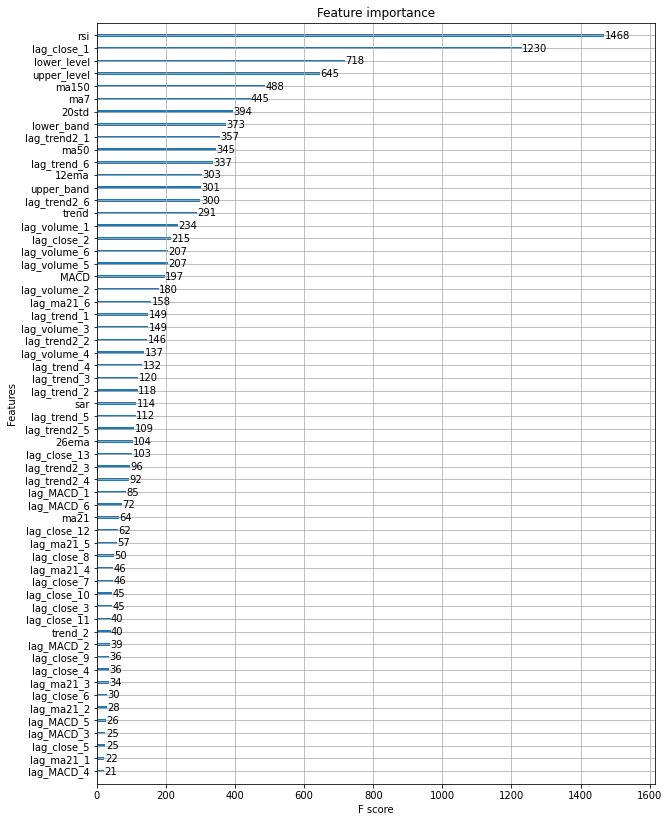

In [ ]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model,(10,14))

In [ ]:
X_test.head()

,High,Low,Open,Volume,ma7,ma21,12ema,26ema,MACD,20std,upper_band,lower_band,ema,sar,rsi,ma50,ma150,trend,upper_level,lower_level,trend_2,lag_close_1,lag_close_2,lag_close_3,lag_close_4,lag_close_5,lag_close_6,lag_close_7,lag_close_8,lag_close_9,lag_close_10,lag_close_11,lag_close_12,lag_close_13,lag_volume_1,lag_trend_1,lag_trend2_1,lag_MACD_1,lag_ma21_1,lag_volume_2,lag_trend_2,lag_trend2_2,lag_MACD_2,lag_ma21_2,lag_volume_3,lag_trend_3,lag_trend2_3,lag_MACD_3,lag_ma21_3,lag_volume_4,lag_trend_4,lag_trend2_4,lag_MACD_4,lag_ma21_4,lag_volume_5,lag_trend_5,lag_trend2_5,lag_MACD_5,lag_ma21_5,lag_volume_6,lag_trend_6,lag_trend2_6,lag_MACD_6,lag_ma21_6
7304,525.900024,510.299988,510.950012,813138.0,509.157144,485.154765,499.261921,489.003624,10.258296,18.786717,522.728198,447.581331,517.109003,470.259705,67.555386,476.301000,455.842000,-20.459000,-3.171826,62.718656,-10.258296,510.450012,511.149994,502.250000,502.850006,504.950012,511.649994,485.100006,470.149994,472.600006,465.750000,474.750000,461.250000,467.600006,480190.0,-19.693333,-8.885993,8.885993,483.373813,1203321.0,-19.076666,-8.059000,8.059000,481.892860,549630.0,-18.422333,-6.814964,6.814964,480.685717,884177.0,-18.095667,-6.034175,6.034175,480.390478,906901.0,-17.871667,-4.888744,4.888744,480.340477,4474732.0,-17.574000,-3.141830,3.141830,480.135715
7305,534.849976,515.500000,520.799988,1619964.0,511.200003,487.521432,503.367781,491.740394,11.627387,20.554629,528.630689,446.412175,523.003009,473.598124,69.275431,477.557001,456.140667,-21.416334,-6.219286,69.087825,-11.627387,520.799988,510.450012,511.149994,502.250000,502.850006,504.950012,511.649994,485.100006,470.149994,472.600006,465.750000,474.750000,461.250000,813138.0,-20.459000,-10.258296,10.258296,485.154765,480190.0,-19.693333,-8.885993,8.885993,483.373813,1203321.0,-19.076666,-8.059000,8.059000,481.892860,549630.0,-18.422333,-6.814964,6.814964,480.685717,884177.0,-18.095667,-6.034175,6.034175,480.390478,906901.0,-17.871667,-4.888744,4.888744,480.340477
7306,545.000000,529.400024,532.799988,1725988.0,516.464286,490.809527,509.280428,495.448512,13.831916,23.536696,537.882919,443.736134,535.534328,478.498273,73.867265,479.138000,456.416667,-22.721333,-7.117081,85.663890,-13.831916,525.950012,520.799988,510.450012,511.149994,502.250000,502.850006,504.950012,511.649994,485.100006,470.149994,472.600006,465.750000,474.750000,1619964.0,-21.416334,-11.627387,11.627387,487.521432,813138.0,-20.459000,-10.258296,10.258296,485.154765,480190.0,-19.693333,-8.885993,8.885993,483.373813,1203321.0,-19.076666,-8.059000,8.059000,481.892860,549630.0,-18.422333,-6.814964,6.814964,480.685717,884177.0,-18.095667,-6.034175,6.034175,480.390478
7307,584.000000,541.000000,544.799988,1731170.0,524.914285,494.907145,517.391131,500.378252,17.012880,27.927604,550.762353,439.051937,553.178109,485.148445,78.315242,481.176000,456.889667,-24.286333,-33.237647,101.948063,-17.012880,541.799988,525.950012,520.799988,510.450012,511.149994,502.250000,502.850006,504.950012,511.649994,485.100006,470.149994,472.600006,465.750000,1725988.0,-22.721333,-13.831916,13.831916,490.809527,1619964.0,-21.416334,-11.627387,11.627387,487.521432,813138.0,-20.459000,-10.258296,10.258296,485.154765,480190.0,-19.693333,-8.885993,8.885993,483.373813,1203321.0,-19.076666,-8.059000,8.059000,481.892860,549630.0,-18.422333,-6.814964,6.814964,480.685717
7308,598.450012,560.000000,570.000000,2941573.0,537.385712,500.380954,528.492494,506.983566,21.508928,34.592257,569.565467,431.196441,577.426028,497.010632,82.652131,483.999000,457.553000,-26.446000,-28.884545,128.803559,-21.508928,562.000000,541.799988,525.950012,520.799988,510.450012,511.149994,502.250000,502.850006,504.950012,511.649994,485.100006,470.149994,472.600006,1731170.0,-24.286333,-17.012880,17.012880,494.907145,1725988.0,-22.721333,-13.831916,13.831916,490.809527,1619964.0,-21.416334,-11.627387,11.627387,487.521432,813138.0,-20.459000,-10.258296,10.258296,485.154765,480190.0,-19.693333,-8.885993,8.885993,483.3

In [ ]:
X_test.loc[7305:7309]

,High,Low,Open,Volume,ma7,ma21,12ema,26ema,MACD,20std,upper_band,lower_band,ema,sar,rsi,ma50,ma150,trend,upper_level,lower_level,trend_2,lag_close_1,lag_close_2,lag_close_3,lag_close_4,lag_close_5,lag_close_6,lag_close_7,lag_close_8,lag_close_9,lag_close_10,lag_close_11,lag_close_12,lag_close_13,lag_volume_1,lag_trend_1,lag_trend2_1,lag_MACD_1,lag_ma21_1,lag_volume_2,lag_trend_2,lag_trend2_2,lag_MACD_2,lag_ma21_2,lag_volume_3,lag_trend_3,lag_trend2_3,lag_MACD_3,lag_ma21_3,lag_volume_4,lag_trend_4,lag_trend2_4,lag_MACD_4,lag_ma21_4,lag_volume_5,lag_trend_5,lag_trend2_5,lag_MACD_5,lag_ma21_5,lag_volume_6,lag_trend_6,lag_trend2_6,lag_MACD_6,lag_ma21_6
7305,534.849976,515.5,520.799988,1619964.0,511.200003,487.521432,503.367781,491.740394,11.627387,20.554629,528.630689,446.412175,523.003009,473.598124,69.275431,477.557001,456.140667,-21.416334,-6.219286,69.087825,-11.627387,520.799988,510.450012,511.149994,502.25,502.850006,504.950012,511.649994,485.100006,470.149994,472.600006,465.75,474.75,461.25,813138.0,-20.459,-10.258296,10.258296,485.154765,480190.0,-19.693333,-8.885993,8.885993,483.373813,1203321.0,-19.076666,-8.059,8.059,481.89286,549630.0,-18.422333,-6.814964,6.814964,480.685717,884177.0,-18.095667,-6.034175,6.034175,480.390478,906901.0,-17.871667,-4.888744,4.888744,480.340477


In [ ]:
row = X_test.loc[7304:7304]
for i in range(1,13):
  if i==1:
     row[f'lag_close_{i}'] = model.predict(row)
  row[f'lag_close_{i+1}'] = row[f'lag_close_{i}']


In [ ]:
model.predict(X_test.loc[7304:7304])

array([518.5267], dtype=float32)

In [ ]:
model.predict(X_test.loc[7304:7309])

array([519.978 , 524.6033, 536.1765, 556.7759, 579.9444, 576.9926],
      dtype=float32)

In [ ]:
Y_test

,Close,close_1,close_2,close_3,close_4,close_5,close_6
7304,520.799988,525.950012,541.799988,562.000000,589.549988,570.299988,556.900024
7305,525.950012,541.799988,562.000000,589.549988,570.299988,556.900024,543.650024
7306,541.799988,562.000000,589.549988,570.299988,556.900024,543.650024,550.400024
7307,562.000000,589.549988,570.299988,556.900024,543.650024,550.400024,570.950012
7308,589.549988,570.299988,556.900024,543.650024,550.400024,570.950012,560.099976
...,...,...,...,...,...,...,...
237471,1426.000000,1439.099976,1413.650024,1392.150024,1388.900024,1384.199951,1386.050049
237472,1439.099976,1413.650024,1392.150024,1388.900024,1384.199951,1386.050049,1391.650024
237473,1413.650024,1392.150024,1388.900024,1384.199951,1386.050049,1391.650024,1447.750000
237474,1392.150024,1388.900024,1384.199951,1386.050049,1391.650024,1447.750000,1434.449951
